In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()

X,y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


(-0.5, 27.5, 27.5, -0.5)

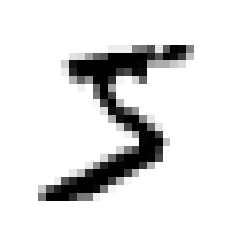

In [5]:
import matplotlib as mp
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis('off')


In [6]:
import numpy as np
# Cast all string targets to int
y = y.astype(np.uint8)

In [7]:
# Train test split is already done
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [16]:
# Making a Binary Classifier (5 and not 5)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [17]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
# Pickling 
import joblib
joblib.dump(sgd, 'sgd.sav')

sgd.predict([some_digit])

array([ True])

In [12]:
# Cross Validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, y_train_5, cv=5, scoring='accuracy')

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [15]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[5915, 6663, 5976, 5314, 6132, 1340, 6045, 5941, 5633, 5620],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [13]:
# Precision (How many predictions were correct) and Recall(How many actual results it could predict)
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred))

# F1 score, harmonic mean of precision and recall
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012 0.6511713705958311
0.7325171197343846


In [14]:
# Raising threshold for classifiction, hence reducing precision
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


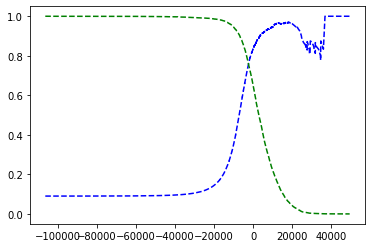

In [15]:
# Make Precision-Recall vs Threshold curve
from sklearn.metrics import precision_recall_curve
from utils import plot_precision_recall_vs_threshold

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(plt, precisions, recalls, thresholds)
plt.show()

In [16]:
# getting 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90))

0.9000345901072293 0.4799852425751706


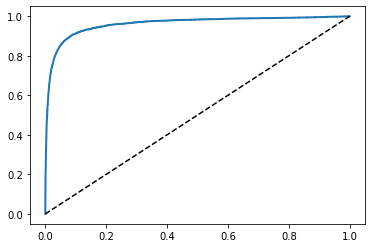

0.9604938554008616


In [17]:
# ROC - receiver operating characterstic
from sklearn.metrics import roc_curve, roc_auc_score
from utils import plot_roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(plt, fpr, tpr)
plt.show()
print(roc_auc_score(y_train_5, y_scores))

In [18]:
#Using a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

y_prob_forest = cross_val_predict(rfc, X_train, y_train_5, cv=3, method="predict_proba")
y_train_pred_rfc = cross_val_predict(rfc, X_train, y_train_5, cv=3)

In [19]:
print(y_prob_forest)

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]


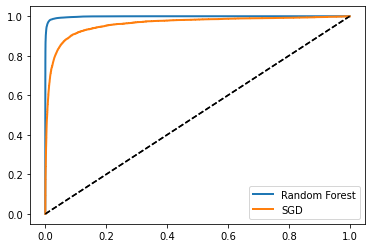

0.9983436731328145
0.9905083315756169 0.8662608374838591


In [20]:
# Make ROC for random forest
y_prob_forest_score = y_prob_forest[:, 1] # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_prob_forest_score)
plot_roc_curve(plt, fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(plt, fpr, tpr, "SGD")
plt.legend(loc="lower right")
plt.show()

print(roc_auc_score(y_train_5, y_prob_forest_score))
print(precision_score(y_train_5, y_train_pred_rfc), recall_score(y_train_5, y_train_pred_rfc))
#e(y_train_5, y_prob_forest), recall_score(y_train_5, y_prob_forest))

In [28]:
# Multiclass Prediction
from sklearn.svm import SVC
import joblib

svc = SVC()
svc.fit(X_train, y_train)
svc.predict([some_digit])

joblib.dump(svc, 'svc.sav')

In [ ]:
# Other Classifiers
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(svc)
ovr_clf.fit(X_train, y_train)

joblib.dump(ovr_clf, 'ovr.sav')

In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

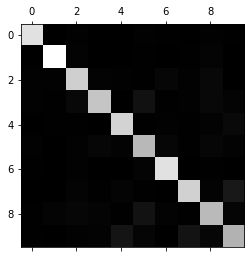

In [18]:
# Confusion Matrix for Multiclass SGD

y_train_pred = cross_val_predict(sgd, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

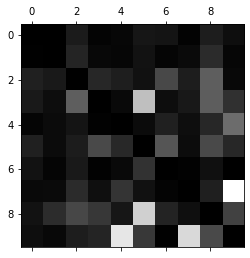

In [22]:
# Seeing errors
rows_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/rows_sum

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# Checking wrong instances
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_perrow=5) 
plt.subplot(222); plot_digits(X_ab[:25], images_perrow=5)
plt.subplot(223); plot_digits(X_ba[:25], images_perrow=5)
plt.subplot(224); plot_digits(X_bb[:25], images_perrow=5)
plt.show()

In [8]:
# Multilabel - (>7 and odd)
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
print(y_multilabel)

[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]]


In [9]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [13]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
